In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. load data from cleaned csv files
train_df = pd.read_csv("../balanced_training_data.csv")
test_df = pd.read_csv("../target.csv")

print("Training Data Columns:", train_df.columns)
print("Test Data Columns:", test_df.columns)



Training Data Columns: Index(['Unnamed: 0', 'filename', 'narrative', 'sub_narrative', 'text',
       'language', 'narrative_labels', 'sub_narrative_labels', 'cleaned'],
      dtype='object')
Test Data Columns: Index(['filename', 'narrative', 'sub_narrative', 'text', 'language',
       'narrative_labels', 'sub_narrative_labels', 'cleaned'],
      dtype='object')


In [2]:
print(train_df['language'].value_counts())
print(train_df['narrative'].value_counts())
print(train_df['sub_narrative'].value_counts())



language
PT    718
EN    549
Name: count, dtype: int64
narrative
Other                                                                                                                                                                                                                                                                                                                            91
CC: Amplifying Climate Fears                                                                                                                                                                                                                                                                                                     23
CC: Amplifying Climate Fears;CC: Amplifying Climate Fears                                                                                                                                                                                                                                      

In [3]:
print(train_df[['narrative', 'narrative_labels']].head())
print(train_df[['sub_narrative', 'sub_narrative_labels']].head())
 

                                           narrative  \
0  CC: Hidden plots by secret schemes of powerful...   
1  URW: Discrediting the West, Diplomacy;URW: Dis...   
2  URW: Blaming the war on others rather than the...   
3  URW: Russia is the Victim;URW: Discrediting th...   
4  URW: Praise of Russia;URW: Discrediting Ukrain...   

                                    narrative_labels  
0  ['CC: Hidden plots by secret schemes of powerf...  
1  ['URW: Discrediting the West, Diplomacy', 'URW...  
2  ['URW: Blaming the war on others rather than t...  
3  ['URW: Russia is the Victim', 'URW: Discrediti...  
4  ['URW: Praise of Russia', 'URW: Discrediting U...  
                                       sub_narrative  \
0  CC: Hidden plots by secret schemes of powerful...   
1  URW: Discrediting the West, Diplomacy: The Wes...   
2  URW: Blaming the war on others rather than the...   
3  URW: Russia is the Victim: UA is anti-RU extre...   
4  URW: Praise of Russia: Russia is a guarantor o... 

In [8]:
# 2. Data Preprocessing
# Extract text data
train_texts = train_df['cleaned'].tolist()
test_texts = test_df['cleaned'].tolist()
print("Number of training samples:", len(train_texts))

Number of training samples: 1267


In [9]:
import nltk
from nltk.corpus import wordnet
from deep_translator import GoogleTranslator
import random

nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(text):
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            new_word = synonyms[0].lemmas()[0].name()
            new_words.append(new_word)
        else:
            new_words.append(word)
    return ' '.join(new_words)
# Back Translation
def back_translate_text(text, src_lang, target_lang):
    try:
        translated = GoogleTranslator(source=src_lang, target=target_lang).translate(text)
        back_translated = GoogleTranslator(source=target_lang, target=src_lang).translate(translated)
        return back_translated
    except Exception as e:
        print(f"Translation failed for text: {text[:50]}... Error: {e}")
        return text 
    
synonym_augmented_texts = [synonym_replacement(text) for text in train_texts] 

back_translate_augmneted_texts = []

train_languages = train_df['language'].tolist()

for text, lang in zip(train_texts, train_languages):
    if lang == "EN":
        back_translate_augmneted_texts.append(back_translate_text(text, "en", "pt"))  
    elif lang == "PT":
        back_translate_augmneted_texts.append(back_translate_text(text, "pt", "en"))  
    else:
        back_translate_augmneted_texts.append(text) 
train_texts.extend(synonym_augmented_texts)
train_texts.extend(back_translate_augmneted_texts)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yujin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yujin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
print("Augmented Train Texts:", len(train_texts))

Augmented Train Texts: 3801


In [11]:

# (TF-IDF )Vectorize texts using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 3))
X_train = tfidf_vectorizer.fit_transform(train_texts)
X_test = tfidf_vectorizer.transform(test_texts)

# Process narrative and subnarrative as multi-label
mlb_narrative = MultiLabelBinarizer()
y_train_narrative = mlb_narrative.fit_transform(train_df['narrative_labels'].apply(lambda x: x.split(';')))
y_test_narrative = mlb_narrative.transform(test_df['narrative_labels'].apply(lambda x: x.split(';')))

mlb_subnarrative = MultiLabelBinarizer()
y_train_subnarrative = mlb_subnarrative.fit_transform(train_df['sub_narrative_labels'].apply(lambda x: x.split(';')))
y_test_subnarrative = mlb_subnarrative.transform(test_df['sub_narrative_labels'].apply(lambda x: x.split(';')))

# Process language as single-label (because each document has only one language)
label_encoder = LabelEncoder()
y_train_lang = label_encoder.fit_transform(train_df['language'])
y_test_lang = label_encoder.transform(test_df['language'])


e:\Anaconda\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ["['CC: Amplifying Climate Fears', 'CC: Amplifying Climate Fears', 'CC: Criticism of climate policies']", "['CC: Amplifying Climate Fears', 'CC: Amplifying Climate Fears', 'CC: Criticism of institutions and authorities']", "['CC: Climate change is beneficial']", "['CC: Criticism of climate movement', 'CC: Criticism of climate movement', 'CC: Criticism of climate movement', 'CC: Questioning the measurements and science']", "['CC: Criticism of climate movement', 'CC: Criticism of climate movement', 'CC: Criticism of institutions and authorities', 'CC: Downplaying climate change', 'CC: Downplaying climate change']", "['CC: Criticism of climate movement', 'CC: Criticism of institutions and authorities', 'CC: Criticism of climate movement', 'CC: Criticism of climate movement']", "['CC: Criticism of climate movement', 'CC: Questioning the measurements and science']", "['CC: Criticism of

In [12]:
import numpy as np
y_train_narrative_augmented = np.vstack([y_train_narrative] * 3)
y_train_subnarrative_augmented = np.vstack([y_train_subnarrative] * 3)
y_train_lang_augmented = np.hstack([y_train_lang] * 3)
print("Narrative labels shape:", y_train_narrative_augmented.shape)
print("Subnarrative labels shape:", y_train_subnarrative_augmented.shape)
print("Language labels shape:", y_train_lang_augmented.shape)

Narrative labels shape: (3801, 268)
Subnarrative labels shape: (3801, 325)
Language labels shape: (3801,)


In [17]:
print("X_train shape:", X_train.shape)
print("y_train_narrative shape:", y_train_narrative_augmented.shape)
print("y_train_subnarrative shape:", y_train_subnarrative_augmented.shape)
print("y_train_lang shape:", y_train_lang_augmented.shape)

X_train shape: (3801, 10000)
y_train_narrative shape: (3801, 268)
y_train_subnarrative shape: (3801, 325)
y_train_lang shape: (3801,)


In [18]:


# 3. Train Model (Random Forest)
# Language
rf_lang = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_lang.fit(X_train, y_train_lang_augmented)
y_pred_lang = rf_lang.predict(X_test)

# narrative
rf_narrative = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_narrative.fit(X_train, y_train_narrative_augmented)
y_pred_narrative = rf_narrative.predict(X_test)

# subnarrative
rf_subnarrative = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_subnarrative.fit(X_train, y_train_subnarrative_augmented)
y_pred_subnarrative = rf_subnarrative.predict(X_test)

# 4. Evaluation
def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# for single-label (Language)
accuracy_lang = calculate_accuracy(y_test_lang, y_pred_lang)

# for multi-label (narrative and subnarrative)
accuracy_narrative = accuracy_score(y_test_narrative, y_pred_narrative)
accuracy_subnarrative = accuracy_score(y_test_subnarrative, y_pred_subnarrative)

print(f"Accuracy for narrative labels: {accuracy_narrative}")
print(f"Accuracy for subnarrative labels: {accuracy_subnarrative}")
print(f"Accuracy for language: {accuracy_lang}")



Accuracy for narrative labels: 0.5
Accuracy for subnarrative labels: 0.631578947368421
Accuracy for language: 1.0


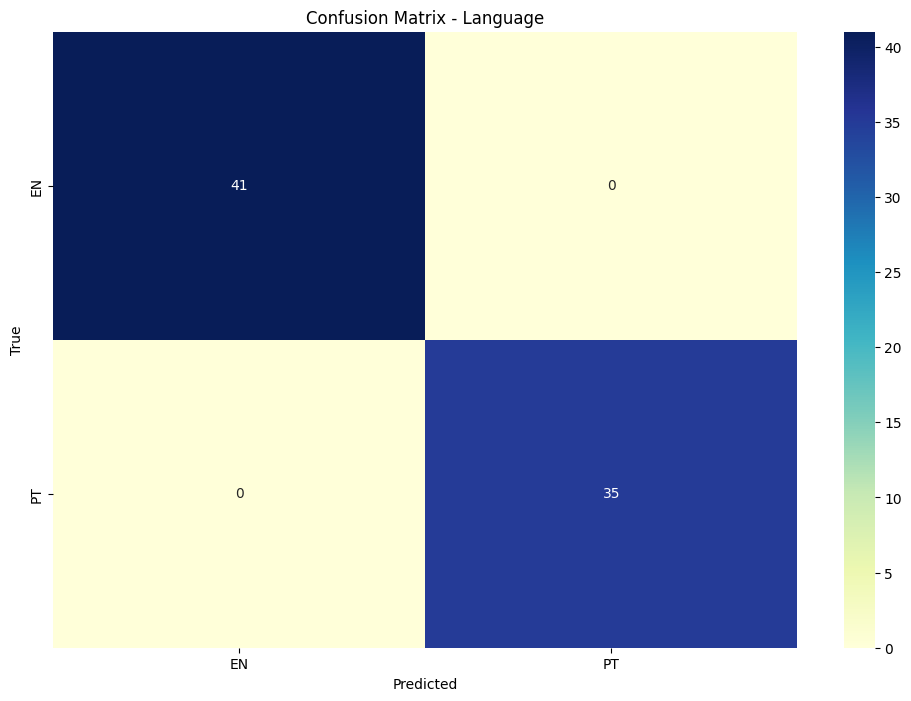

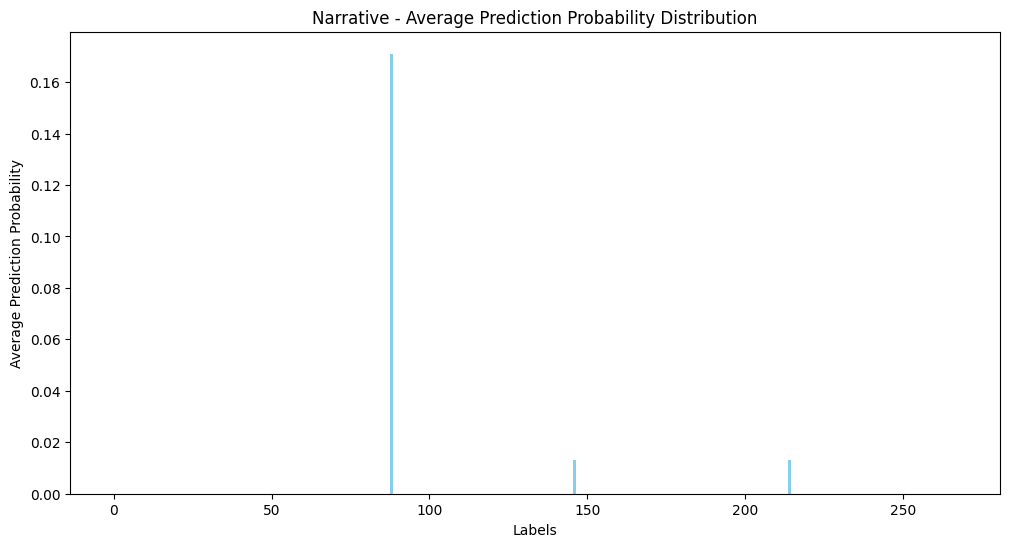

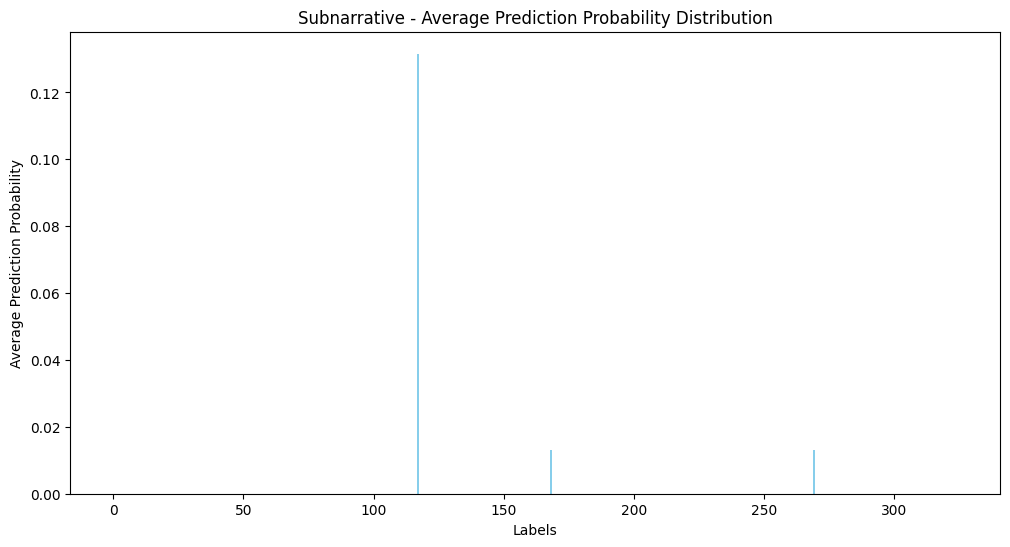

In [20]:
# 5. Visualization
# Confusion Matrix (Language)
def plot_confusion_matrix(y_test, y_pred, classes, title):
    cm = confusion_matrix(y_test, y_pred) 
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


plot_confusion_matrix(
    y_test_lang, y_pred_lang,
    classes=label_encoder.classes_,
    title="Confusion Matrix - Language"
)

# Visualization of the prediction probability distribution (Narrative and Subnarrative)
def plot_probability_distribution(y_pred, title):
    avg_prob = y_pred.mean(axis=0)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(avg_prob)), avg_prob, color="skyblue")
    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Average Prediction Probability")
    plt.show()

plot_probability_distribution(y_pred_narrative, "Narrative - Average Prediction Probability Distribution")
plot_probability_distribution(y_pred_subnarrative, "Subnarrative - Average Prediction Probability Distribution")


Language Metrics (Accuracy, Precision, Recall, F1): (1.0, 1.0, 1.0, 1.0)
Narrative Metrics (Accuracy, Precision, Recall, F1): (0.5, 0.4666666666666667, 0.175, 0.2545454545454545)
Subnarrative Metrics (Accuracy, Precision, Recall, F1): (0.631578947368421, 0.5833333333333334, 0.22580645161290322, 0.32558139534883723)


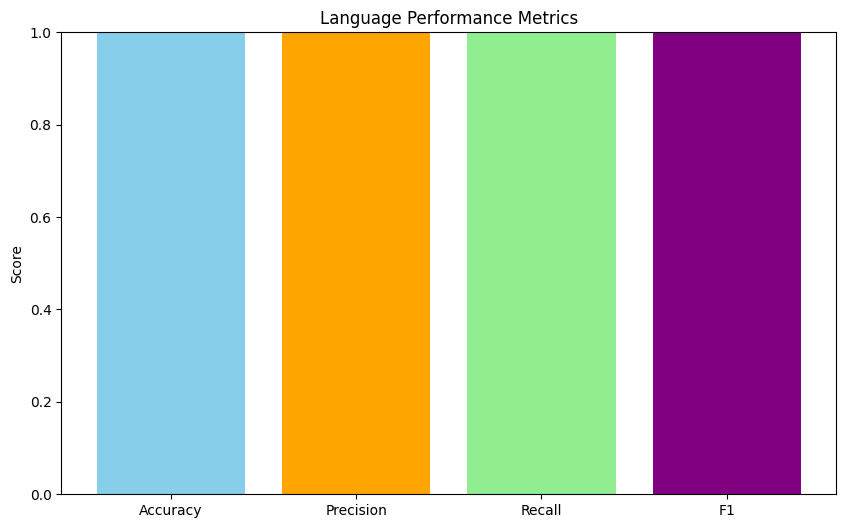

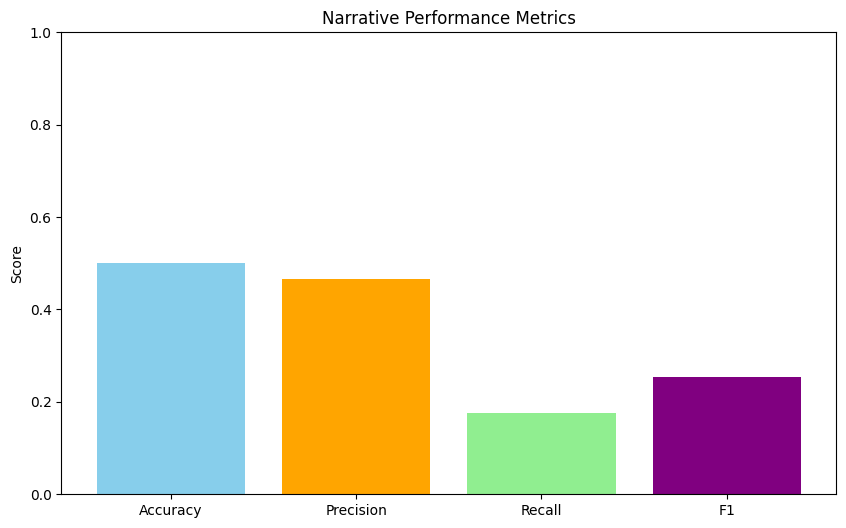

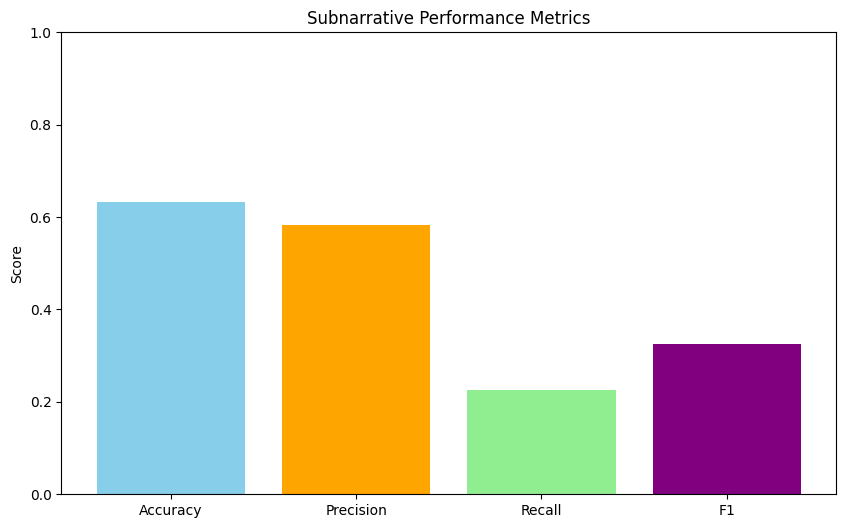

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, average_method="micro"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_method)
    recall = recall_score(y_true, y_pred, average=average_method)
    f1 = f1_score(y_true, y_pred, average=average_method)
    return accuracy, precision, recall, f1

def plot_metrics_comparison(language_metrics, narrative_metrics, subnarrative_metrics):
    categories = ['Accuracy', 'Precision', 'Recall', 'F1']
    x = range(len(categories))

    data = {
        'Language': language_metrics,
        'Narrative': narrative_metrics,
        'Subnarrative': subnarrative_metrics
    }

    for key, metrics in data.items():
        plt.figure(figsize=(10, 6))
        plt.bar(x, metrics, color=['skyblue', 'orange', 'lightgreen', 'purple'])
        plt.xticks(x, categories)
        plt.ylim(0, 1)
        plt.title(f'{key} Performance Metrics')
        plt.ylabel('Score')
        plt.show()

# Calculate metrics for each task
lang_metrics = calculate_metrics(y_test_lang, y_pred_lang, average_method="macro")
narrative_metrics = calculate_metrics(y_test_narrative, y_pred_narrative, average_method="micro")
subnarrative_metrics = calculate_metrics(y_test_subnarrative, y_pred_subnarrative, average_method="micro")

# Print metrics
print(f"Language Metrics (Accuracy, Precision, Recall, F1): {lang_metrics}")
print(f"Narrative Metrics (Accuracy, Precision, Recall, F1): {narrative_metrics}")
print(f"Subnarrative Metrics (Accuracy, Precision, Recall, F1): {subnarrative_metrics}")

# Plot metrics comparison
plot_metrics_comparison(lang_metrics, narrative_metrics, subnarrative_metrics)